In [29]:
import chardet
import pandas as pd
import numpy as np
from scipy.spatial import distance
from pyproj import Transformer
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium

In [30]:
import matplotlib as mpl
mpl.rc('font', family='AppleGothic')


In [31]:
def open_with_auto_sensing_encoding_types(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
        result = chardet.detect(rawdata)
        encoding_type = result['encoding']

    print(f"파일의 인코딩: {encoding_type}")
    # 감지된 인코딩으로 파일 읽기
    df = pd.read_csv(file_path, encoding=encoding_type)
    print(len(df))
    return df

In [32]:
target_path = "/Users/yujin/Desktop/파일/3-1/데이터분석 공모전/codes/입지분석2/유성/data/preprocessed_target.csv"
taget_df = open_with_auto_sensing_encoding_types(target_path)

파일의 인코딩: utf-8
1765


In [33]:
taget_df.head(3)

,Unnamed: 0,행정동,경도,위도,subway_최소거리(m),500m지하철역개수,bus_최소거리(m),500m버스정류장개수,badplace_최소거리(m),500m술집개수,child_protection_최소거리(m),300m보호구역개수,accident_최소거리(m),200m내위험구역개수,parking_최소거리(m),500내주차장개수
0,0,자양4동,127.057131,37.529359,943.105681,0,658.159095,0,678.069180,0,1283.829239,0,1148.133137,0,550.087297,0
1,1,자양4동,127.058268,37.528462,827.611715,0,636.487794,0,580.961545,0,1178.187396,0,1028.175732,0,489.745395,0
2,2,자양4동,127.058263,37.529363,818.040769,0,584.165586,0,566.033273,1,1161.653603,0,1022.444612,0,448.508335,0


In [34]:
taget_df["행정동"].value_counts()

광장동     276
중곡4동    229
자양2동    162
구의3동    146
구의2동    137
화양동     118
자양4동    115
자양3동    114
능동      110
군자동      75
중곡3동     60
중곡1동     59
자양1동     57
구의1동     55
중곡2동     52
Name: 행정동, dtype: int64

In [35]:

def view_distribute_and_get_mean_dist(series):
    '''
    @param:
    series (pd.Series) : 수치형 시리즈 데이터

    기능:
    - 데이터의 분포 곡선 출력 (Seaborn KDE plot)
    - 평균과 표준편차 계산

    @return:
    mean, std (float64) : 평균, 표준편차
    '''
    if not isinstance(series, pd.Series):
        raise TypeError("입력은 pandas.Series 형식이어야 합니다.")

    # 평균, 표준편차 계산
    mean = series.mean()
    std = series.std()

    # 분포 곡선 시각화
    plt.figure(figsize=(8, 4))
    sns.kdeplot(series, fill=True, color='skyblue', linewidth=2)
    plt.axvline(mean, color='red', linestyle='--', label=f'평균: {mean:.2f}')
    plt.axvline(mean + std, color='green', linestyle='--', label=f'평균+표준편차: {mean + std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='--', label=f'평균-표준편차: {mean - std:.2f}')
    plt.title("데이터 분포 곡선")
    plt.xlabel("값")
    plt.ylabel("밀도")
    plt.legend()
    plt.grid(True)
    plt.show()

    return mean, std


In [36]:
taget_df.columns

Index(['Unnamed: 0', '행정동', '경도', '위도', 'subway_최소거리(m)', '500m지하철역개수',
       'bus_최소거리(m)', '500m버스정류장개수', 'badplace_최소거리(m)', '500m술집개수',
       'child_protection_최소거리(m)', '300m보호구역개수', 'accident_최소거리(m)',
       '200m내위험구역개수', 'parking_최소거리(m)', '500내주차장개수'],
      dtype='object')

# 데이터분석

## 간단하게 모든 데이터의 분포 및 표준편차 확인해보기

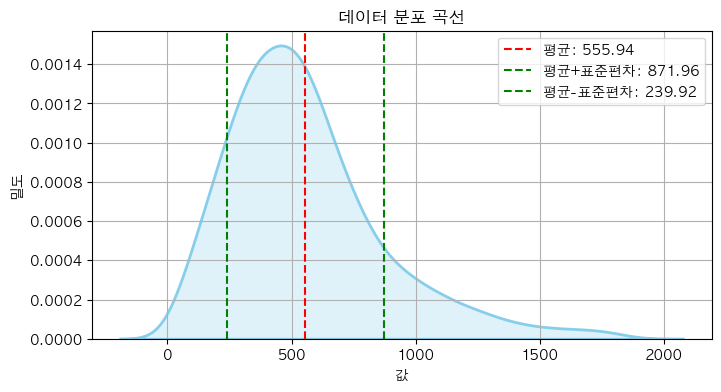

[subway_최소거리(m)] → mean : 555.94, std : 316.02



/Users/yujin/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


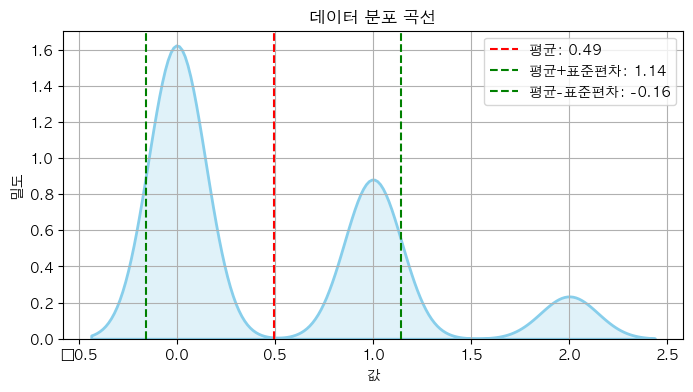

지하철역개수] → mean : 0.49, std : 0.65



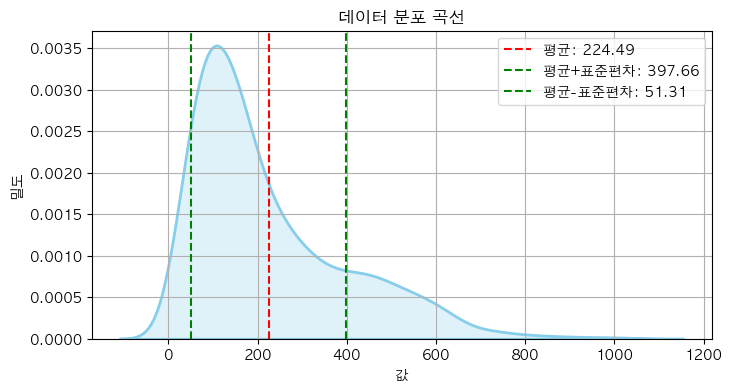

[bus_최소거리(m)] → mean : 224.49, std : 173.17



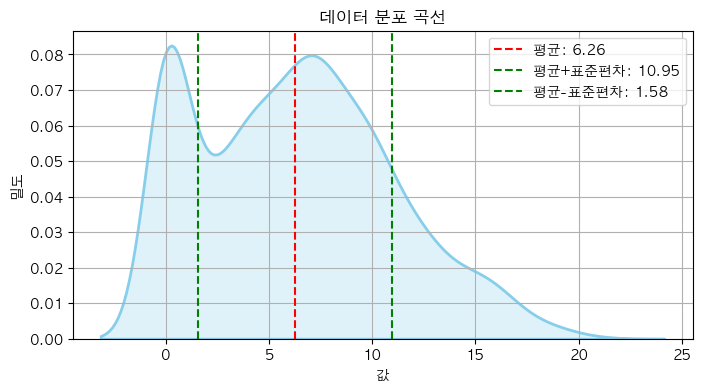

버스정류장개수] → mean : 6.26, std : 4.69



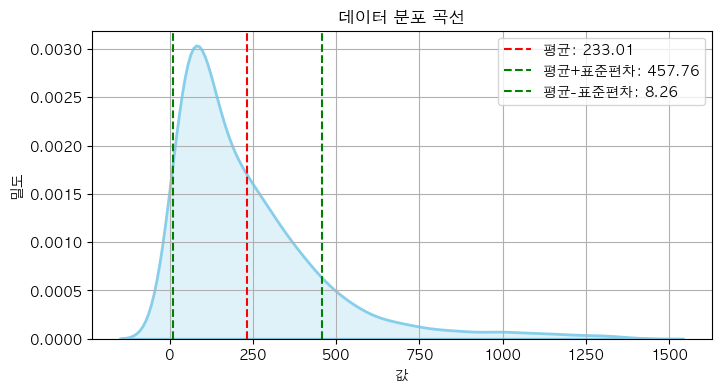

[badplace_최소거리(m)] → mean : 233.01, std : 224.75



/Users/yujin/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


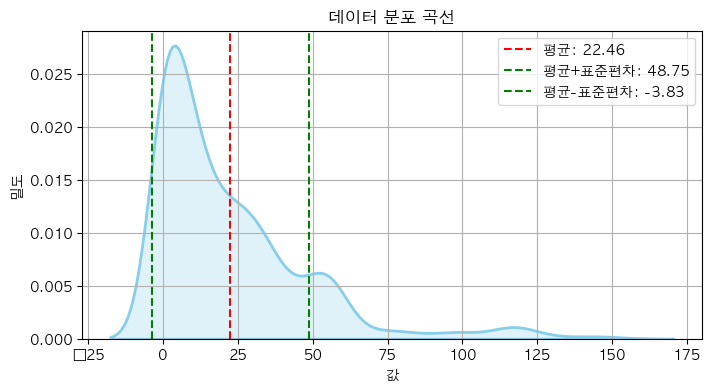

술집개수] → mean : 22.46, std : 26.29



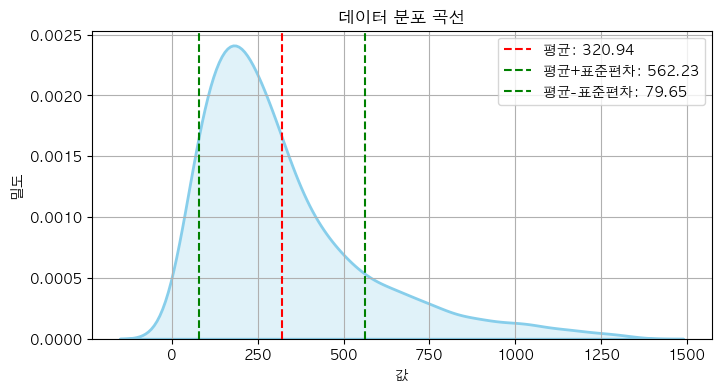

[child_protection_최소거리(m)] → mean : 320.94, std : 241.29



/Users/yujin/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


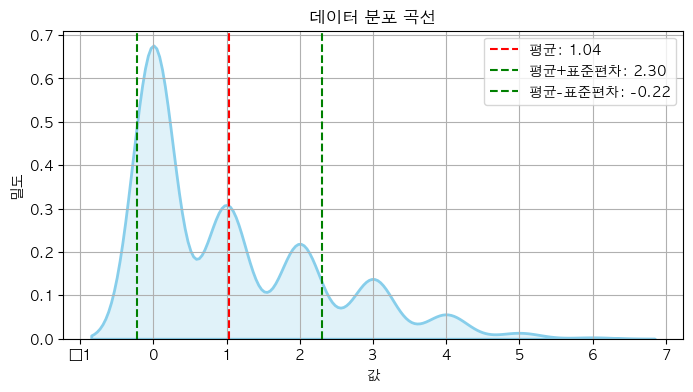

보호구역개수] → mean : 1.04, std : 1.26



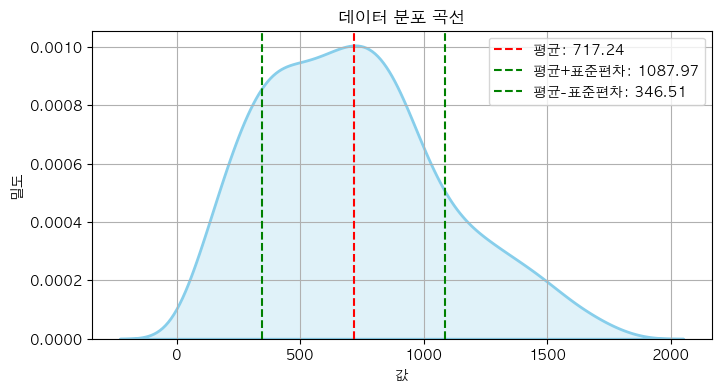

[accident_최소거리(m)] → mean : 717.24, std : 370.73



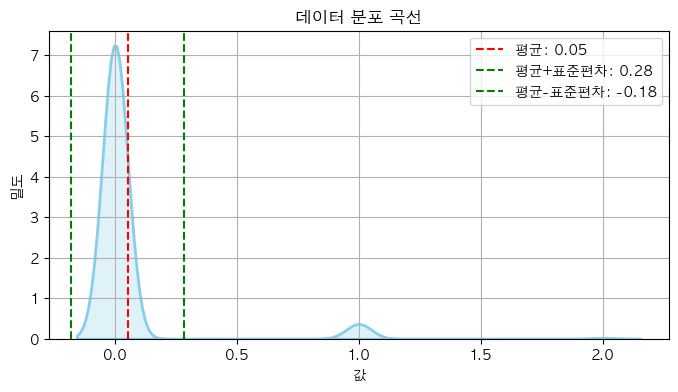

내위험구역개수] → mean : 0.05, std : 0.23



/Users/yujin/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


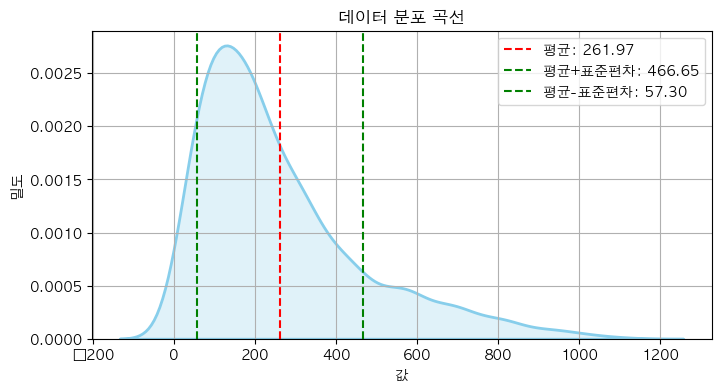

[parking_최소거리(m)] → mean : 261.97, std : 204.68



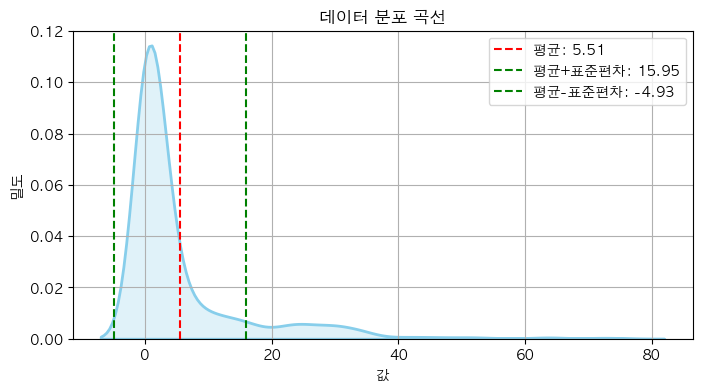

[500내주차장개수] → mean : 5.51, std : 10.44



In [37]:
columns = [
    'subway_최소거리(m)', '500m지하철역개수',
    'bus_최소거리(m)', '500m버스정류장개수',
    'badplace_최소거리(m)', '500m술집개수',
    'child_protection_최소거리(m)', '300m보호구역개수',
    'accident_최소거리(m)', '200m내위험구역개수',
    'parking_최소거리(m)', '500내주차장개수'
]

mean_list = []
std_list = []

for col in columns:
    mean, std = view_distribute_and_get_mean_dist(taget_df[col])
    mean_list.append(mean)
    std_list.append(std)
    print(f"[{col}] → mean : {mean:.2f}, std : {std:.2f}\n")


In [38]:
print(taget_df.head(3))

   Unnamed: 0   행정동          경도         위도  subway_최소거리(m)  500m지하철역개수  \
0           0  자양4동  127.057131  37.529359      943.105681           0   
1           1  자양4동  127.058268  37.528462      827.611715           0   
2           2  자양4동  127.058263  37.529363      818.040769           0   

   bus_최소거리(m)  500m버스정류장개수  badplace_최소거리(m)  500m술집개수  \
0   658.159095            0        678.069180         0   
1   636.487794            0        580.961545         0   
2   584.165586            0        566.033273         1   

   child_protection_최소거리(m)  300m보호구역개수  accident_최소거리(m)  200m내위험구역개수  \
0               1283.829239           0       1148.133137            0   
1               1178.187396           0       1028.175732            0   
2               1161.653603           0       1022.444612            0   

   parking_최소거리(m)  500내주차장개수  
0       550.087297          0  
1       489.745395          0  
2       448.508335          0  


### 데이터들의 표준편차가 모두다 큰 편이다

#### 지하철역 관련
[subway_최소거리(m)] → mean : 555.94, std : 316.02

[500m지하철역개수] → mean : 0.49, std : 0.65

- [500m지하철역개수] 제거

#### 버스정류장 관련
[bus_최소거리(m)] → mean : 224.49, std : 173.17

[500m버스정류장개수] → mean : 6.26, std : 4.69

- 그대로 사용

#### 유해시설 관련
[badplace_최소거리(m)] → mean : 233.01, std : 224.75

[500m술집개수] → mean : 22.46, std : 26.29

- 그대로 사용

#### 어린이 보호구역 관련
[child_protection_최소거리(m)] → mean : 320.94, std : 241.29

[300m보호구역개수] → mean : 1.04, std : 1.26

- child_protection_최소거리(m) 열 제거, 300m내 0개 :0, 300m내 1개 이상 : 1 로 라벨링

#### 사고다발지점 관련
[accident_최소거리(m)] → mean : 717.24, std : 370.73

[200m내위험구역개수] → mean : 0.05, std : 0.23

- accident_최소거리(m) 열 제거, 200m내 0개 :0, 300m내 1개 이상 : 1 로 라벨링

#### 주차장 관련
[parking_최소거리(m)] → mean : 261.97, std : 204.68

[500내주차장개수] → mean : 5.51, std : 10.44


In [39]:
import pandas as pd

# 예시로 target_df를 불러왔다고 가정 (네가 따로 불러오면 이 부분은 생략해도 됨)
# target_df = pd.read_csv("your_file.csv")

# 1. 어린이 보호구역 관련 전처리
# 'child_protection_최소거리(m)' 제거
taget_df.drop(columns=['child_protection_최소거리(m)'], inplace=True)

# '300m보호구역개수'를 0이면 0, 1 이상이면 1로 이진 라벨링
taget_df['300m보호구역여부'] = (taget_df['300m보호구역개수'] >= 1).astype(int)
taget_df.drop(columns=['300m보호구역개수'], inplace=True)

# 2. 사고다발지점 관련 전처리
# 'accident_최소거리(m)' 제거
taget_df.drop(columns=['accident_최소거리(m)'], inplace=True)

# '200m내위험구역개수'를 0이면 0, 1 이상이면 1로 이진 라벨링
taget_df['200m위험구역여부'] = (taget_df['200m내위험구역개수'] >= 1).astype(int)
taget_df.drop(columns=['200m내위험구역개수'], inplace=True)

# 결과 확인
taget_df.head()


,Unnamed: 0,행정동,경도,위도,subway_최소거리(m),500m지하철역개수,bus_최소거리(m),500m버스정류장개수,badplace_최소거리(m),500m술집개수,parking_최소거리(m),500내주차장개수,300m보호구역여부,200m위험구역여부
0,0,자양4동,127.057131,37.529359,943.105681,0,658.159095,0,678.069180,0,550.087297,0,0,0
1,1,자양4동,127.058268,37.528462,827.611715,0,636.487794,0,580.961545,0,489.745395,0,0,0
2,2,자양4동,127.058263,37.529363,818.040769,0,584.165586,0,566.033273,1,448.508335,0,0,0
3,3,자양4동,127.058257,37.530265,812.868007,0,533.568661,0,550.211772,1,412.046497,0,0,0
4,4,자양4동,127.058252,37.531166,812.177464,0,485.237012,0,504.338347,1,381.033788,0,0,0


In [40]:
df_gwangjang = taget_df[taget_df['행정동'] == '광장동'].copy()

# 분석에 사용할 주요 변수 목록
features = ['subway_최소거리(m)',
            'bus_최소거리(m)', '500m버스정류장개수',
            'badplace_최소거리(m)', '500m술집개수',
            'parking_최소거리(m)', '500내주차장개수',
            '300m보호구역여부', '200m위험구역여부'
            ]

# 주요 변수만 추출
X = df_gwangjang[features].values

# 사고다발지역 관련 변수에 가중치 부여 (중요도 높이기 위해 두 배로 확대)
accident_indices = [features.index('300m보호구역여부'), features.index('200m위험구역여부')]
X[:, accident_indices] *= 2.0

# 데이터 표준화 (StandardScaler 사용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

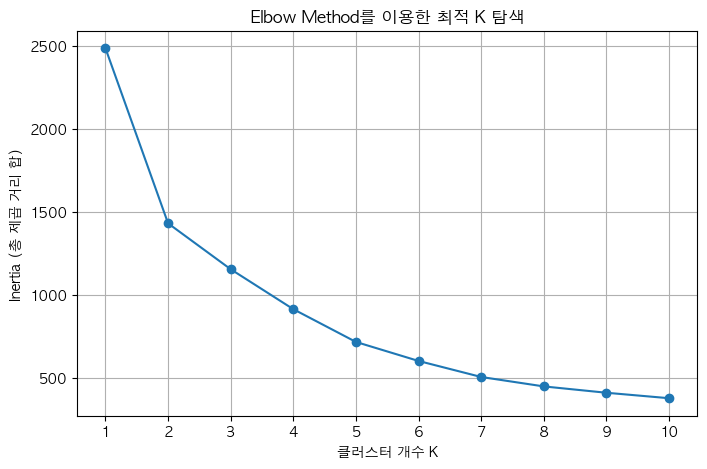

In [41]:
# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method: 군집 수에 따른 inertia 계산
inertias = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xticks(K_range)
plt.xlabel('클러스터 개수 K')
plt.ylabel('Inertia (총 제곱 거리 합)')
plt.title('Elbow Method를 이용한 최적 K 탐색')
plt.grid(True)
plt.show()


In [42]:
from sklearn.metrics import silhouette_score
# 최적 군집 수 결정: 엘보우와 실루엣 계산
inertias = []
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    score = silhouette_score(X_scaled, labels_temp) # type: ignore
    sil_scores.append(score)
    print("클러스터 갯수 : ", k , " silhouette_score :", score)

# (inertias 리스트와 sil_scores 리스트를 이용해 그래프를 그려 엘보우 형태와 실루엣 점수 변화를 분석)

클러스터 갯수 :  2  silhouette_score : 0.3616651787804981
클러스터 갯수 :  3  silhouette_score : 0.3655275709255716
클러스터 갯수 :  4  silhouette_score : 0.34793986288356643
클러스터 갯수 :  5  silhouette_score : 0.35663990257421674
클러스터 갯수 :  6  silhouette_score : 0.3721593256385445
클러스터 갯수 :  7  silhouette_score : 0.3858632374287429
클러스터 갯수 :  8  silhouette_score : 0.3733834741298995
클러스터 갯수 :  9  silhouette_score : 0.37771525387629307
클러스터 갯수 :  10  silhouette_score : 0.3647581676149179


# KNN 기반 군집화

In [43]:

# 클러스터링 실행 (확장 가능한 구조로)
optimal_k = 4  # 원하는 K값으로 설정
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# 라벨을 원본 데이터프레임에 추가
df_gwangjang['cluster'] = labels

# 군집별 평균값 계산 (features는 클러스터링에 사용한 변수 리스트)
knn_cluster_means = df_gwangjang.groupby('cluster')[features].mean()

# 각 군집의 중심 좌표 계산 (표준화된 공간)
cluster_centers = kmeans.cluster_centers_

# 각 군집에 대해 실제 데이터 중에서 군집 중심에 가장 가까운 좌표를 찾음
rep_coords = {}
for cluster_id in range(optimal_k):
    members = np.where(labels == cluster_id)[0]  # 해당 군집 소속 인덱스
    center = cluster_centers[cluster_id]
    
    # 표준화 공간에서 거리 계산
    dists = np.linalg.norm(X_scaled[members] - center, axis=1)
    rep_index = members[np.argmin(dists)]  # 대표 좌표 인덱스
    
    # 군집 ID 기준으로 대표 좌표 저장 (경도, 위도)
    rep_coords[cluster_id] = {
        'lon': df_gwangjang.iloc[rep_index]['경도'],
        'lat': df_gwangjang.iloc[rep_index]['위도']
    }

# 결과 예시 출력



In [44]:
knn_cluster_means

,subway_최소거리(m),bus_최소거리(m),500m버스정류장개수,badplace_최소거리(m),500m술집개수,parking_최소거리(m),500내주차장개수,300m보호구역여부,200m위험구역여부
cluster,,,,,,,,,
0,548.598505,157.337732,5.182796,210.060517,6.784946,438.285446,0.000000,0.591398,0.0
1,818.343749,421.257524,0.780702,386.053244,1.114035,620.860916,0.026316,0.105263,0.0
2,361.263025,143.246885,6.652174,159.144065,7.869565,177.982037,1.130435,0.978261,0.0
3,298.005045,125.825693,7.000000,92.616661,10.913043,355.722741,0.260870,1.000000,1.0


In [45]:
print("Representative coordinates for each grade:", rep_coords)

Representative coordinates for each grade: {0: {'lon': 127.100084962874, 'lat': 37.5394272294874}, 1: {'lon': 127.107918692689, 'lat': 37.5565792222389}, 2: {'lon': 127.104555501894, 'lat': 37.5502585354828}, 3: {'lon': 127.10571606941, 'lat': 37.5448542934907}}


# GMM 알고리즘 기반, Mahalanobis 거리 이용한 군집화

In [46]:
from sklearn.mixture import GaussianMixture
from numpy.linalg import inv

구의1동_df = taget_df[taget_df['행정동'] == '광장동'].copy()



# 2. 분석에 사용할 변수 지정
positive_features = [  # 가까울수록 좋고 / 개수 많을수록 좋음
    'subway_최소거리(m)',
    'bus_최소거리(m)', '500m버스정류장개수',
    'badplace_최소거리(m)', '500m술집개수',
    '300m보호구역여부'
]
negative_features = [  # 멀수록 좋고 / 개수 적을수록 좋음
    '200m위험구역여부',
    'parking_최소거리(m)', '500내주차장개수'
]
features = positive_features + negative_features

# 3. 표준화 (z-score 정규화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(구의1동_df[features])

# 4. 마할라노비스 거리 기반 방향 반영을 위한 sign 처리
# → 긍정적 변수는 반전(-), 부정적 변수는 그대로(+)
flip_sign = np.array([-1 if f in positive_features else 1 for f in features])
X_adjusted = X_scaled * flip_sign

# 5. GMM 군집화: AIC 기반으로 최적 군집 수 탐색
lowest_aic = np.inf
best_gmm = None
n_components_range = range(2, 7)  # 군집 수 후보
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_adjusted)
    aic = gmm.aic(X_adjusted)
    if aic < lowest_aic:
        lowest_aic = aic
        best_gmm = gmm

# 6. 최적 모델로 예측 및 라벨 저장
구의1동_df['cluster'] = best_gmm.predict(X_adjusted)

# 7. 군집별 평균값 확인
gmm_cluster_means = 구의1동_df.groupby('cluster')[features].mean()



/var/folders/6q/q927ypwn4ll9d4rvjq9gl1qw0000gn/T/ipykernel_89129/3858028451.py:32: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/yujin/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


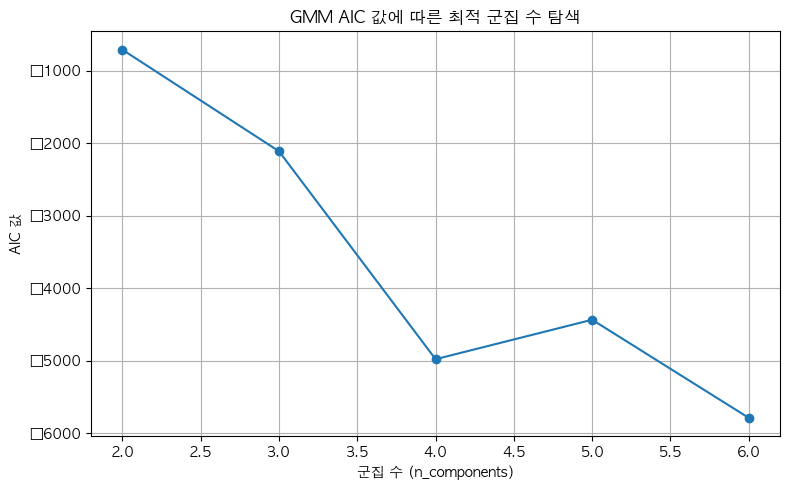

In [47]:
import matplotlib.pyplot as plt

# AIC 그래프 생성을 위한 리스트 초기화
aic_values = []
n_components_range = range(2, 7)  # 기존과 동일하게 사용

# GMM 학습 및 AIC 저장
lowest_aic = np.inf
best_gmm = None
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_adjusted)
    aic = gmm.aic(X_adjusted)
    aic_values.append(aic)
    if aic < lowest_aic:
        lowest_aic = aic
        best_gmm = gmm

# 클러스터 할당
구의1동_df['cluster'] = best_gmm.predict(X_adjusted)

# 군집별 평균값 확인
gmm_cluster_means = 구의1동_df.groupby('cluster')[features].mean()

# AIC 시각화
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, aic_values, marker='o', linestyle='-')
plt.title('GMM AIC 값에 따른 최적 군집 수 탐색')
plt.xlabel('군집 수 (n_components)')
plt.ylabel('AIC 값')
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
# 9. 결과 출력
print("최적 군집 수:", best_gmm.n_components)

최적 군집 수: 6


In [49]:
gmm_cluster_means


,subway_최소거리(m),bus_최소거리(m),500m버스정류장개수,badplace_최소거리(m),500m술집개수,300m보호구역여부,200m위험구역여부,parking_최소거리(m),500내주차장개수
cluster,,,,,,,,,
0,298.005045,125.825693,7.000000,92.616661,10.913043,1.0,1.0,355.722741,0.260870
1,1044.804077,404.506196,0.800000,259.211002,2.000000,0.0,0.0,749.256431,0.000000
2,377.679656,106.748266,6.000000,118.614960,12.600000,0.9,0.0,335.049045,1.100000
3,691.712345,151.238562,5.418605,210.227618,5.441860,0.0,0.0,477.283016,0.000000
4,644.079278,459.541930,0.659574,512.834613,0.234043,0.0,0.0,560.445332,0.000000
5,435.889225,192.724293,4.980583,228.899134,6.300971,1.0,0.0,311.150022,0.427184


In [50]:
# print("등급 매핑:", grade_map if len(knn_cluster_means) >= 3 else "군집 수 부족으로 등급 생략됨")


In [51]:
구의1동_df[['경도', '위도', 'cluster'] + features].head()

,경도,위도,cluster,subway_최소거리(m),bus_최소거리(m),500m버스정류장개수,badplace_최소거리(m),500m술집개수,300m보호구역여부,200m위험구역여부,parking_최소거리(m),500내주차장개수
1218,127.094406,37.543013,2,532.519994,78.426080,5,160.337223,22,1,0,425.357698,0
1219,127.094401,37.543915,3,592.974703,111.682258,6,206.631332,21,0,0,464.582903,0
1265,127.095543,37.542116,0,481.049675,69.899193,8,31.353786,17,1,1,504.059097,0
1266,127.095538,37.543017,2,540.390283,87.791693,6,84.335799,18,1,0,530.618413,0
1267,127.095533,37.543918,2,599.966452,129.174169,5,129.072972,17,1,0,562.459673,0


In [52]:
def visualize2map(df, output_html="구의1동_cluster_map.html"):
    """
    folium을 사용하여 클러스터 시각화 지도 생성 + 콘솔에 색상 매핑 출력

    Parameters:
    - df: 클러스터가 포함된 DataFrame
    - output_html: 저장할 HTML 파일명
    """
    center_lat = df["위도"].mean()
    center_lon = df["경도"].mean()
    map_obj = folium.Map(location=[center_lat, center_lon], zoom_start=16)

    # 클러스터 수와 색상 생성
    unique_clusters = sorted(df["cluster"].unique())
    n_clusters = len(unique_clusters)
    cmap = plt.get_cmap('tab10') if n_clusters <= 10 else plt.get_cmap('tab20')
    cluster_colors = {cluster: cmap(i % cmap.N) for i, cluster in enumerate(unique_clusters)}

    def rgb_to_hex(rgb):
        return '#%02x%02x%02x' % tuple(int(255 * x) for x in rgb[:3])

    cluster_colors = {k: rgb_to_hex(v) for k, v in cluster_colors.items()}

    # 마커 추가
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row["위도"], row["경도"]],
            radius=6,
            color=cluster_colors[row["cluster"]],
            fill=True,
            fill_color=cluster_colors[row["cluster"]],
            fill_opacity=0.7,
            popup=f'Cluster: {row["cluster"]}, 행정동: {row["행정동"]}'
        ).add_to(map_obj)

    map_obj.save(output_html)

    # 색상 설명 사전
    simple_color_names = {
        '#1f77b4': 'Blue 🔵',
        '#ff7f0e': 'Orange 🔶',
        '#2ca02c': 'Green 🟢',
        '#d62728': 'Red 🔴',
        '#9467bd': 'Purple 🟣',
        '#8c564b': 'Brown 🟤',
        '#e377c2': 'Pink 🌸',
        '#7f7f7f': 'Gray ⚫',
        '#bcbd22': 'Olive 💚',
        '#17becf': 'Cyan 🧊',
    }

    # 출력
    print("📌 클러스터 색상 매핑:")
    for cluster, hex_color in cluster_colors.items():
        name = simple_color_names.get(hex_color.lower(), '')
        display = f"{name} " if name else ""
        print(f"  {display}Cluster {cluster}: {hex_color}")

    print(f"\n✅ 지도가 '{output_html}'에 저장되었습니다.")


In [53]:
visualize2map(구의1동_df, output_html="광장동_gnn_cluster_map.html")

📌 클러스터 색상 매핑:
  Blue 🔵 Cluster 0: #1f77b4
  Orange 🔶 Cluster 1: #ff7f0e
  Green 🟢 Cluster 2: #2ca02c
  Red 🔴 Cluster 3: #d62728
  Purple 🟣 Cluster 4: #9467bd
  Brown 🟤 Cluster 5: #8c564b

✅ 지도가 '광장동_gnn_cluster_map.html'에 저장되었습니다.


In [54]:
구의1동_df.head()

,Unnamed: 0,행정동,경도,위도,subway_최소거리(m),500m지하철역개수,bus_최소거리(m),500m버스정류장개수,badplace_최소거리(m),500m술집개수,parking_최소거리(m),500내주차장개수,300m보호구역여부,200m위험구역여부,cluster
1218,1218,광장동,127.094406,37.543013,532.519994,0,78.426080,5,160.337223,22,425.357698,0,1,0,2
1219,1219,광장동,127.094401,37.543915,592.974703,0,111.682258,6,206.631332,21,464.582903,0,0,0,3
1265,1265,광장동,127.095543,37.542116,481.049675,0,69.899193,8,31.353786,17,504.059097,0,1,1,0
1266,1266,광장동,127.095538,37.543017,540.390283,0,87.791693,6,84.335799,18,530.618413,0,1,0,2
1267,1267,광장동,127.095533,37.543918,599.966452,0,129.174169,5,129.072972,17,562.459673,0,1,0,2


In [55]:
visualize2map(df_gwangjang, output_html="광장동_knn_cluster_map.html")

📌 클러스터 색상 매핑:
  Blue 🔵 Cluster 0: #1f77b4
  Orange 🔶 Cluster 1: #ff7f0e
  Green 🟢 Cluster 2: #2ca02c
  Red 🔴 Cluster 3: #d62728

✅ 지도가 '광장동_knn_cluster_map.html'에 저장되었습니다.


In [56]:
df_gwangjang.to_csv("knn_cluster_광장동.csv")
구의1동_df.to_csv("gmm_cluster_광장동.csv")

In [57]:
df_gwangjang.head()

,Unnamed: 0,행정동,경도,위도,subway_최소거리(m),500m지하철역개수,bus_최소거리(m),500m버스정류장개수,badplace_최소거리(m),500m술집개수,parking_최소거리(m),500내주차장개수,300m보호구역여부,200m위험구역여부,cluster
1218,1218,광장동,127.094406,37.543013,532.519994,0,78.426080,5,160.337223,22,425.357698,0,1,0,0
1219,1219,광장동,127.094401,37.543915,592.974703,0,111.682258,6,206.631332,21,464.582903,0,0,0,0
1265,1265,광장동,127.095543,37.542116,481.049675,0,69.899193,8,31.353786,17,504.059097,0,1,1,3
1266,1266,광장동,127.095538,37.543017,540.390283,0,87.791693,6,84.335799,18,530.618413,0,1,0,0
1267,1267,광장동,127.095533,37.543918,599.966452,0,129.174169,5,129.072972,17,562.459673,0,1,0,0
